In an attempt to shed some light over the few extra set of acetylated sites (beyond Foxp3) found in the Cre+/g5 vs Cre+/NTC samples, we had the following questions:
1. What is the genomic annotation distribution of those acetylated sites?
2. On average, are genes differentially expressed around those peaks having sig. diff. binding signal? How about those that do not show sig. diff. binding signal?

Additionally, how do these results compare with a similar analysis focusing on the effect of Cre (g5 and Cre+ v Cre-)?  

First, let's annotated the closest gene to each K27ac peak:

In [1]:
%%bash
module load bedtools2
#     -a <(tail -n+2 /data/reddylab/Keith/collab/200924_Gemberling/analysis/201209_Gemberling2020_K27acChIP-seq_DESeq2_hits_q2.tsv \
bedtools closest -d \
    -a <(tail -n+2 /data/reddylab/Keith/collab/200924_Gemberling/analysis/201211_Gemberling2020_K27acChIP-seq_DESeq2_CREpos_G5_v_NTC_allpeaks.tsv \
    | cut -f2- | sort -k1,1 -k2,2g) \
    -b <(sort -k1,1 -k2,2n /data/reddylab/Reference_Data/Gencode/vM19/gencode.vM19.basic.annotation.TSS.bed) \
> /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/201211_Gemberling2020_K27acChIP-seq_DESeq2_CREpos_G5_v_NTC_allpeaks.with_genes.bed


In [36]:
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['lines.markersize'] = 5
import seaborn as sns
import pandas as pd
import numpy as np
from palettable.cartocolors.qualitative import Bold_8_r

In [2]:
df = pd.read_csv('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/201211_Gemberling2020_K27acChIP-seq_DESeq2_CREpos_G5_v_NTC_allpeaks.with_genes.bed', sep='\t', 
                 header=None)

In [3]:
def distance_to_genomic_anno(d):
    if d < 3000:
        return "Promoter <=3kb"
    return "Distal >3kb"

In [4]:
df['genomic_anno'] = df.apply(lambda x: distance_to_genomic_anno(x[19]), axis=1)

In [5]:
sns.set_context('notebook')

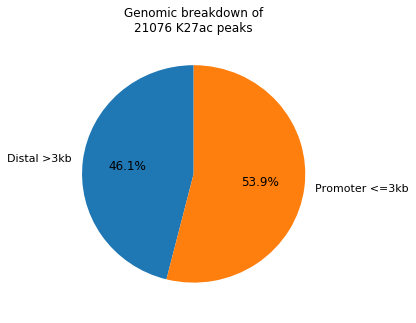

In [7]:
fig, ax = plt.subplots(figsize=[5, 5])
pd.DataFrame(
    df.groupby('genomic_anno').count()[0].values,
    columns = ['genomic_dist'],
    index = df.groupby('genomic_anno').count()[0].index,
            ).plot.pie('genomic_dist', ax=ax, startangle=90,  autopct='%1.1f%%')
plt.ylabel('')
ax.get_legend().remove()
plt.title("Genomic breakdown of\n%d K27ac peaks" % df.shape[0]);
# plt.tight_layout()
plt.savefig('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/offtargets/KS150.CrePos.g5_vs_KS150.CrePos.NTC.all_peaks.closest_gene.geno_anno_pie.pdf')

### Next, extract fold-changes of genes in matching RNA-seq data

First, let's add the coordinates to each gene

In [7]:
degs = pd.read_csv('/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/KS150.CrePos.g5_vs_KS150.CrePos.NTC.unshrunk.with_genes.txt', sep='\t')

In [7]:
degs[degs.padj<0.01].head()

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000039521.12,177.280446,3.489987,0.374454,9.320199,1.161228e-20,1.380932e-16,Foxp3,protein_coding


In [8]:
!head -n1 /data/reddylab/Reference_Data/Gencode/vM19/gencode.vM19.basic.annotation.TSS.bed

chr1	3671497	3671498	ENSMUSG00000051951.5	.	-	Xkr4	protein_coding


In [8]:
tss_headers = ['tss_chrom', 'tss_start', 'tss_end', 'gene_ensembl_id', 'tss_score', 'tss_strand', 'gene_symbol', 'gene_type']

In [9]:
merged = df.merge(degs, left_on=14, right_on='Unnamed: 0', how='inner')

In [9]:
!head -n1 /data/reddylab/Keith/collab/200924_Gemberling/analysis/201209_Gemberling2020_K27acChIP-seq_DESeq2_hits_q2.tsv

Geneid	Chr	Start	End	Strand	Length	baseMean	log2FoldChange	lfcSE	stat	pvalue	padj


In [6]:
def get_enrich_group(x, fdr_thres=0.01):
    if (x[10] < fdr_thres) and (x['padj'] < fdr_thres):
        return 'sig. DEG; sig. DA'
    if (x[10] < fdr_thres) and (x['padj'] >= fdr_thres):
        return 'nonsig. DEG; sig. DA'
    if (x[10] >= fdr_thres) and (x['padj'] < fdr_thres):
        return 'sig. DEG; nonsig. DA'
    return 'nonsig. DEG; nonsig. DA'
    

In [10]:
fdr_thres = 0.01
merged['group (FDR<%.2f)' % fdr_thres] = merged.apply(get_enrich_group, fdr_thres=fdr_thres, axis = 1)

In [11]:
sns.set_context('notebook')

In [12]:
colors = ['grey'] + Bold_8_r.hex_colors[1:2] + [Bold_8_r.hex_colors[3]]

In [13]:
colors

['grey', '#E68310', '#E73F74']

In [17]:
colors = ['grey', '#008695', '#E73F74'] #, '#E68310']

In [20]:
hue_order = merged['group (FDR<%.2f)' % fdr_thres].unique()

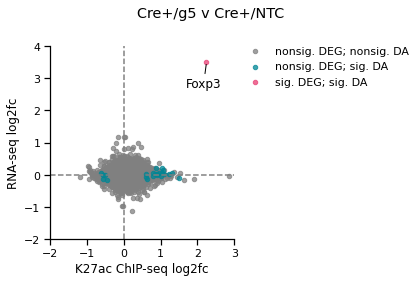

In [22]:
fig, ax = plt.subplots(figsize=[6, 4])
# sns.scatterplot(data = merged, x=6, y='log2FoldChange', hue = 'group (FDR<%.2f)' % fdr_thres, 
#                 palette= colors, s=20, edgecolor=None, alpha=.75)
for ix in range(len(hue_order)):
    ax.scatter(
        merged.loc[merged['group (FDR<%.2f)' % fdr_thres]==hue_order[ix], 6], 
        merged.loc[merged['group (FDR<%.2f)' % fdr_thres]==hue_order[ix], 'log2FoldChange'], 
        color=colors[ix], s=20, alpha=.75, edgecolor=None, 
        rasterized= True if ix in [0] else False, 
        label=hue_order[ix],
        zorder=ix
    )


xlims = [np.floor(merged[6].min()), np.ceil(merged[6].max())]
ylims = [np.floor(merged['log2FoldChange'].min()), np.ceil(merged['log2FoldChange'].max())]
plt.xlim(xlims) 
plt.ylim(ylims)
plt.vlines(0, ylims[0], ylims[1], linestyle='--', color='grey')
plt.hlines(0, xlims[0], xlims[1], linestyle='--', color='grey')

for x, y, t in zip(
    merged[6].values, 
    merged['log2FoldChange'].values, 
    merged['GeneName']) :
    if t != 'Foxp3': continue
    ax.annotate('{}'.format(t), xy=(x, y), 
                xytext=(.75*x, .75*y), #xytext=(5, 0), 
                ha='left', va='bottom', #ha='left',
                arrowprops=dict(arrowstyle='-', color='black'))

plt.legend(bbox_to_anchor=(1, 1.05), frameon=False)
plt.ylabel('RNA-seq log2fc')
plt.xlabel('K27ac ChIP-seq log2fc')
fig.suptitle('Cre+/g5 v Cre+/NTC')

sns.despine()
plt.tight_layout()
plt.savefig('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/offtargets/KS150.CrePos.g5_vs_KS150.CrePos.NTC.all_peaks.closest_gene.pdf')


In [45]:
chipseq_headers = !head -n1 /data/reddylab/Keith/collab/200924_Gemberling/analysis/201209_Gemberling2020_K27acChIP-seq_DESeq2_hits_q2.tsv
chipseq_headers = ['K27ac_%s' % c for c in chipseq_headers[0].split()]

In [46]:
['foo'] + ['bar']

['foo', 'bar']

In [47]:
degs.columns = ['rnaseq_%s'% c  if c != 'Unnamed: 0' else 'rnaseq_ensemblID'  for c in degs.columns ]

In [55]:
merged_columns = chipseq_headers + tss_headers + ['genomic_anno'] + degs.columns.values.tolist() + ['group (FDR<%.2f)' % fdr_thres]

In [56]:
merged.columns = merged_columns

In [57]:
merged.to_csv('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/offtargets/KS150.CrePos.g5_vs_KS150.CrePos.NTC.all_peaks.closest_gene.txt', 
              sep='\t', header=True, index=False)

--- 
What about Cre+ v Cre-?

In [34]:
%%bash
module load bedtools2
bedtools closest -d \
    -a <(tail -n+2 /data/reddylab/Keith/collab/200924_Gemberling/analysis/201211_Gemberling2020_K27acChIP-seq_DESeq2_CREpos_v_CREneg_G5_allpeaks.tsv \
    | cut -f2- | sort -k1,1 -k2,2g) \
    -b <(sort -k1,1 -k2,2n /data/reddylab/Reference_Data/Gencode/vM19/gencode.vM19.basic.annotation.TSS.bed) \
> /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/201211_Gemberling2020_K27acChIP-seq_DESeq2_CREpos_v_CREneg_G5_allpeaks.with_genes.bed


In [24]:
df = pd.read_csv('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/201211_Gemberling2020_K27acChIP-seq_DESeq2_CREpos_v_CREneg_G5_allpeaks.with_genes.bed', sep='\t', 
                 header=None)

In [25]:
def distance_to_genomic_anno(d):
    if d < 3000:
        return "Promoter <=3kb"
    return "Distal >3kb"

In [26]:
df['genomic_anno'] = df.apply(lambda x: distance_to_genomic_anno(x[19]), axis=1)

In [27]:
sns.set_context('notebook')

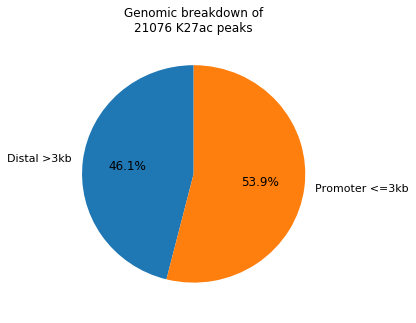

In [38]:
fig, ax = plt.subplots(figsize=[5, 5])
pd.DataFrame(
    df.groupby('genomic_anno').count()[0].values,
    columns = ['genomic_dist'],
    index = df.groupby('genomic_anno').count()[0].index,
            ).plot.pie('genomic_dist', ax=ax, startangle=90,  autopct='%1.1f%%')
plt.ylabel('')
ax.get_legend().remove()
plt.title("Genomic breakdown of\n%d K27ac peaks" % df.shape[0]);
# plt.tight_layout()
plt.savefig('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/offtargets/KS150.CrePos.g5_vs_KS150.CreNeg.g5.all_peaks.closest_gene.geno_anno_pie.pdf')

### Next, extract fold-changes of genes in matching RNA-seq data

First, let's add the coordinates to each gene

In [14]:
degs = pd.read_csv('/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/redo/nextseq/KS150.CrePos.g5_vs_KS150.CreNeg.g5.unshrunk.with_genes.txt', sep='\t')

In [15]:
degs[degs.padj<0.01].shape

(3427, 9)

In [28]:
merged = df.merge(degs, left_on=14, right_on='Unnamed: 0', how='inner')

In [62]:
!head -n1 /data/reddylab/Keith/collab/200924_Gemberling/analysis/201209_Gemberling2020_K27acChIP-seq_DESeq2_hits_q2.tsv

Geneid	Chr	Start	End	Strand	Length	baseMean	log2FoldChange	lfcSE	stat	pvalue	padj


In [29]:
def get_enrich_group(x, fdr_thres=0.01):
    if (x[10] < fdr_thres) and (x['padj'] < fdr_thres):
        return 'sig. DEG; sig. DA'
    if (x[10] < fdr_thres) and (x['padj'] >= fdr_thres):
        return 'nonsig. DEG; sig. DA'
    if (x[10] >= fdr_thres) and (x['padj'] < fdr_thres):
        return 'sig. DEG; nonsig. DA'
    return 'nonsig. DEG; nonsig. DA'
    

In [30]:
fdr_thres = 0.01
merged['group (FDR<%.2f)' % fdr_thres] = merged.apply(get_enrich_group, fdr_thres=fdr_thres, axis = 1)

In [31]:
merged['group (FDR<%.2f)' % fdr_thres].unique()

array(['nonsig. DEG; nonsig. DA', 'nonsig. DEG; sig. DA',
       'sig. DEG; nonsig. DA', 'sig. DEG; sig. DA'], dtype=object)

In [32]:
sns.set_context('notebook')

In [33]:
colors = ['grey'] + Bold_8_r.hex_colors[:2] + [Bold_8_r.hex_colors[3]]

In [14]:
merged.groupby( 'group (FDR<%.2f)' % fdr_thres).count()

,0,1,2,3,4,5,6,7,8,9,...,genomic_anno,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
group (FDR<0.01),,,,,,,,,,,,,,,,,,,,,
nonsig. DEG; nonsig. DA,7529,7529,7529,7529,7529,7529,7529,7529,7529,7528,...,7529,7529,7529,7529,7529,7529,7528,7528,7529,7529
nonsig. DEG; sig. DA,2619,2619,2619,2619,2619,2619,2619,2619,2619,2619,...,2619,2619,2619,2619,2619,2619,2619,2619,2619,2619
sig. DEG; nonsig. DA,3248,3248,3248,3248,3248,3248,3248,3248,3248,3248,...,3248,3248,3248,3248,3248,3248,3248,3248,3248,3248
sig. DEG; sig. DA,1383,1383,1383,1383,1383,1383,1383,1383,1383,1383,...,1383,1383,1383,1383,1383,1383,1383,1383,1383,1383


In [34]:
hue_order = merged['group (FDR<%.2f)' % fdr_thres].unique()

foo


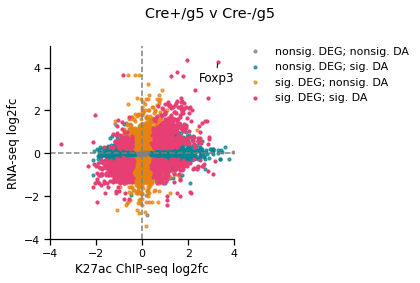

In [40]:
fig, ax = plt.subplots(figsize=[6, 4])
# ff = sns.scatterplot(data = merged, x=6, y='log2FoldChange', hue = 'group (FDR<%.2f)' % fdr_thres, 
#                 palette= colors, s=20, edgecolor=None, alpha=.65)
for ix in range(len(hue_order)):
    ax.scatter(
        merged.loc[merged['group (FDR<%.2f)' % fdr_thres]==hue_order[ix], 6], 
        merged.loc[merged['group (FDR<%.2f)' % fdr_thres]==hue_order[ix], 'log2FoldChange'], 
        color=colors[ix], s=10, alpha=0.75 if ix!=3 else 1, 
        edgecolor=None, #alpha=.75
        rasterized= False, # True if ix in [0,1,2] else False, 
        label=hue_order[ix],
        zorder=ix
    )


xlims = [np.floor(merged[6].min()), np.ceil(merged[6].max())]
ylims = [np.floor(merged['log2FoldChange'].min()), np.ceil(merged['log2FoldChange'].max())]
plt.xlim(xlims) 
plt.ylim(ylims)
plt.vlines(0, ylims[0], ylims[1], linestyle='--', color='grey')
plt.hlines(0, xlims[0], xlims[1], linestyle='--', color='grey')

for x, y, t in zip(
    merged[6].values, 
    merged['log2FoldChange'].values, 
    merged['GeneName']) :
    if t != 'Foxp3': continue
    print ("foo")
    ax.annotate('{}'.format(t), xy=(x, y), 
                xytext=(.75*x, .75*y), #xytext=(5, 0), 
                ha='left', va='bottom', #ha='left',
                arrowprops=dict(arrowstyle='-', color='black'))

plt.legend(bbox_to_anchor=(1, 1.05), frameon=False)
plt.ylabel('RNA-seq log2fc')
plt.xlabel('K27ac ChIP-seq log2fc')
fig.suptitle('Cre+/g5 v Cre-/g5')

sns.despine()
plt.tight_layout()
plt.savefig('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/offtargets/KS150.CrePos.g5_vs_KS150.CreNeg.g5.all_peaks.closest_gene.high_res.pdf')

In [38]:
merged[(merged['GeneName'] == 'Foxp3')]

,0,1,2,3,4,5,6,7,8,9,...,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType,group (FDR<0.01)
14372,chrX,7578787,7580637,+,1851,101.057714,3.274606,0.230227,14.22338,6.560644e-46,...,ENSMUSG00000039521.12,182.911222,4.263198,0.396205,10.760091,5.311782e-27,1.610267e-23,Foxp3,protein_coding,sig. DEG; sig. DA


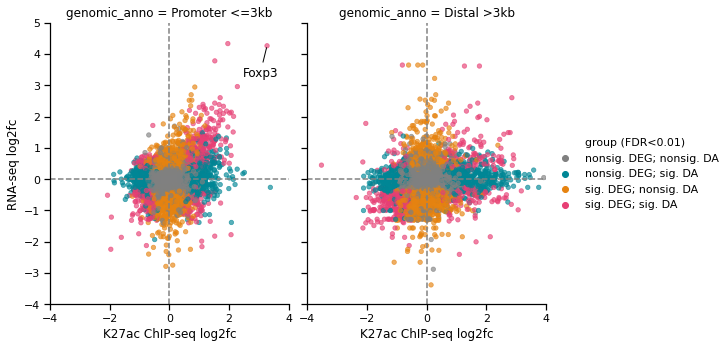

In [61]:
# fig, ax = plt.subplots(figsize=[6, 4])
ff = sns.relplot(data = merged, x=6, y='log2FoldChange', hue = 'group (FDR<%.2f)' % fdr_thres, aspect=.8,
                palette= colors, s=20, edgecolor=None, alpha=.65, col='genomic_anno', legend='brief')
xlims = [np.floor(merged[6].min()), np.ceil(merged[6].max())]
ylims = [np.floor(merged['log2FoldChange'].min()), np.ceil(merged['log2FoldChange'].max())]
plt.xlim(xlims) 
plt.ylim(ylims)
for ax in ff.axes[0]:
    ax.vlines(0, ylims[0], ylims[1], linestyle='--', color='grey')
    ax.hlines(0, xlims[0], xlims[1], linestyle='--', color='grey')

for x, y, t in zip(
    merged[6].values, 
    merged['log2FoldChange'].values, 
    merged['GeneName']) :
    if t != 'Foxp3': continue
    ff.axes[0][0].annotate('{}'.format(t), xy=(x, y), 
                xytext=(.75*x, .75*y), #xytext=(5, 0), 
                ha='left', va='bottom', #ha='left',
                arrowprops=dict(arrowstyle='-', color='black'))

leg = ff._legend
leg.set_bbox_to_anchor=([1, .7])
leg.set_frameon=False
# leg._loc=3

plt.ylabel('RNA-seq log2fc')
plt.xlabel('K27ac ChIP-seq log2fc')
ff.set_axis_labels(x_var='K27ac ChIP-seq log2fc', y_var='RNA-seq log2fc')
fig.suptitle('Cre+/g5 v Cre-/g5')

sns.despine()
# plt.tight_layout()
plt.savefig('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/offtargets/KS150.CrePos.g5_vs_KS150.CreNeg.g5.all_peaks.closest_gene.relplot.pdf')
